# Aprendizado Profundo (Ext. Artibutos RP) - Fine tuning

Estruturação de pipeline baseado em aprendizado raso utilizando atributos extraídos via Deep Learning dos RPs.


# Configurações

In [1]:
import os
import sys
import gc
import json
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *

from pretty_confusion_matrix import *

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS
RESIDENCIA = 3

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "27") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")
caminho_ukdale = os.path.join(caminho_dados, "UK-DALE")

# Path completo do arquivo REDD/UKDALE
arquivo_dataset_redd = os.path.join(caminho_redd, "redd.h5")
arquivo_dataset_ukdale = os.path.join(caminho_ukdale, "ukdale.h5")

# # VARIAVEL AUXILIAR
# # Path dos arquivos relacionados as janelas
# caminho_janelas = os.path.join(caminho_redd, "../../phd")
# if not os.path.isdir(caminho_janelas):
#     os.makedirs(caminho_janelas)

In [3]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

# Dados

## Base REDD

In [4]:
# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset_redd):
    from nilmtk.dataset_converters import convert_redd
    
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset_redd)

# Carregando dataset REDD no objeto NILMTK
# Exemplo de carregamento da base REDD no NILMTK
import h5py # * Evitar erro de incompatibilidade entre h5py e nilmtk
from nilmtk import DataSet
from nilmtk.utils import print_dict

redd = DataSet(arquivo_dataset_redd)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()

NILMTK -> Detalhes sobre o dataset REDD:


## UK-DALE

In [5]:
ukdale = DataSet(arquivo_dataset_ukdale)
print("NILMTK -> Detalhes sobre o dataset UK-DALE:")
print_dict(ukdale.metadata)
print()

NILMTK -> Detalhes sobre o dataset UK-DALE:


In [6]:
from datetime import datetime, timedelta
from dateutil.parser import parse as date_parser

date_parser(ukdale.metadata['timeframe']['start'])

datetime.datetime(2012, 11, 9, 22, 28, 15, tzinfo=tzutc())

In [7]:
date_parser(ukdale.metadata['timeframe']['end'])

datetime.datetime(2015, 1, 5, 6, 26, 44, tzinfo=tzutc())

In [8]:
(date_parser(ukdale.metadata['timeframe']['start']) + timedelta(days=30)).strftime('%Y-%m-%d')

'2012-12-09'

In [9]:
# Quantidade de dias registrados na base redd
for b in redd.buildings:
    print(f'House #{b}')
    for m in redd.buildings[b].elec.all_meters():
        if m.label().lower() == 'site meter':
            history = m.power_series_all_data()
            start = history.index[0]
            end = history.index[-1]
            interval = history.index[-1] - history.index[0]
            print(' -', m.label(), f'({m.instance()})')
            print(f"   De {start.strftime('%d/%m/%Y %H:%M:%S')} a {end.strftime('%d/%m/%Y %H:%M:%S')}")
            print(f"   Duração: {interval}")
        # else:
        #     label = m.label().lower().replace(' ','_')
        #     if not any(map(label.__contains__, aparelhos_janelas.keys())):
        #         aparelhos_janelas[label] = JANELA_PADRAO
            

# b = redd.buildings[3]
# b.elec.all_meters()[2].power_series_all_data().index[[0, -1]]


House #1
 - Site meter (1)
   De 18/04/2011 09:22:09 a 24/05/2011 15:57:02
   Duração: 36 days 06:34:53
 - Site meter (2)
   De 18/04/2011 09:22:09 a 24/05/2011 15:57:02
   Duração: 36 days 06:34:53
House #2
 - Site meter (1)
   De 17/04/2011 19:18:27 a 22/05/2011 19:59:16
   Duração: 35 days 00:40:49
 - Site meter (2)
   De 17/04/2011 19:18:27 a 22/05/2011 19:59:16
   Duração: 35 days 00:40:49
House #3
 - Site meter (1)
   De 16/04/2011 01:11:27 a 30/05/2011 20:19:54
   Duração: 44 days 19:08:27
 - Site meter (2)
   De 16/04/2011 01:11:27 a 30/05/2011 20:19:54
   Duração: 44 days 19:08:27
House #4
 - Site meter (1)
   De 16/04/2011 21:16:19 a 03/06/2011 20:45:45
   Duração: 47 days 23:29:26
 - Site meter (2)
   De 16/04/2011 21:16:19 a 03/06/2011 20:45:45
   Duração: 47 days 23:29:26
House #5
 - Site meter (1)
   De 18/04/2011 00:24:03 a 31/05/2011 20:20:20
   Duração: 43 days 19:56:17
 - Site meter (2)
   De 18/04/2011 00:24:03 a 31/05/2011 20:20:20
   Duração: 43 days 19:56:17
House

In [10]:
# Quantidade de dias registrados na base ukdale
for b in ukdale.buildings:
    print(f'House #{b}')
    for m in ukdale.buildings[b].elec.all_meters():
        if m.label().lower() == 'site meter':
            history = m.power_series_all_data()
            start = history.index[0]
            end = history.index[-1]
            interval = history.index[-1] - history.index[0]
            print(' -', m.label(), f'({m.instance()})')
            print(f"   De {start.strftime('%d/%m/%Y %H:%M:%S')} a {end.strftime('%d/%m/%Y %H:%M:%S')}")
            print(f"   Duração: {interval}")
        # else:
        #     label = m.label().lower().replace(' ','_')
        #     if not any(map(label.__contains__, aparelhos_janelas.keys())):
        #         aparelhos_janelas[label] = JANELA_PADRAO

House #1
 - Site meter (54)
   De 17/03/2013 19:12:43 a 05/01/2015 06:27:12
   Duração: 658 days 11:14:28.900000
 - Site meter (1)
   De 09/11/2012 22:28:15 a 05/01/2015 06:15:46
   Duração: 786 days 07:47:31
House #2
 - Site meter (20)
   De 16/04/2013 21:45:16 a 10/10/2013 06:16:00
   Duração: 176 days 08:30:44.200000
 - Site meter (1)
   De 17/02/2013 16:17:34 a 10/10/2013 06:15:50
   Duração: 234 days 12:58:16
House #3
 - Site meter (1)
   De 27/02/2013 20:35:14 a 08/04/2013 06:14:53
   Duração: 39 days 08:39:39
House #4
 - Site meter (1)
   De 09/03/2013 14:40:07 a 01/10/2013 06:15:07
   Duração: 205 days 14:35:00
House #5
 - Site meter (26)
   De 29/06/2014 17:23:43 a 13/11/2014 20:35:25
   Duração: 137 days 04:11:41.899999
 - Site meter (1)
   De 29/06/2014 17:23:48 a 13/11/2014 17:52:24
   Duração: 137 days 01:28:36


## Melhores Combinações de Taxas e Janelas para cada Aparelho (artigo IEEE-2021)

In [11]:
df_melhores_taxas_janelas = pd.read_csv(
    os.path.join(caminho_dados, "27", "melhores_taxa_janela_aparelhos_ieee2021.csv"), 
    index_col=0)[['carga', 'taxa_amostragem', 'janela']]
df_melhores_taxas_janelas

,carga,taxa_amostragem,janela
0,dish_washer - 9,2,2040
1,fridge - 7,2,720
2,microwave - 16,2,900
3,washer_dryer - 13,2,90
4,washer_dryer - 14,3,2040


In [12]:
# Melhores configurações de janelas por aparelhos, conforme 
#  artigo IEEE (https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/6287639/9312710/9564044/ferna.t3-3118947-large.gif),
#  independente do nomenclatura/instancia da base REDD.
with open(
    os.path.join(caminho_dados_notebook, "config_aparelhos_janelas_ieee2021.json"), 
    'r') as f:
    aparelhos_janelas = json.load(f)
print(aparelhos_janelas)
# * obs.: como a base redd (artigo) possui dois washer_dryer's, onde verificou-se
#         duas configurações distintas de janelas (90 e 2040), vamos usar a maior.

# Atualizando cargas para exportacao (assumindo janela padrao)
JANELA_PADRAO = 900 # 30 minutos

# Qtd de aparelhos q mais consomem energia
TOP_K = 5

{'dish': 2040, 'fridge': 720, 'microwave': 900, 'washer_dryer': 2040, 'washing_machine': 2040}


In [13]:
# TODO: 
# - Desenvolver módulo da metodologia na lib PyNILM 

## Parâmetros de RP dos Aparelhos (estudo 18)

In [14]:
# Carregando arquivos de parametros, caso n estejam (kernel reiniciado)
if not 'parametros_rp_aparelho' in locals():
    with open(os.path.join(caminho_dados, "18", "parametros_rp_aparelho.json"),'r') as arquivo:
        parametros_rp_aparelho = json.load(arquivo)

## Ambiente e Funções Auxiliares

In [15]:
# from PyNILM.dados.janelas import Janelas
from PyNILM.dados.janelas import Janelas
from PyNILM.dados.utils import *

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from PyNILM.modelos.utils import *
from PyNILM.modelos.dlafe import DLAFE
from PyNILM.modelos.rqa import RQA

# Inicializar uso GPU
start_tf_session(memory_limit=int(1024*4))

Virtual devices cannot be modified after being initialized


## Configurações do Experimento

In [16]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# # Teste da classe
# # janelas_treino = Janelas(
# #     base=DataSet(arquivo_dataset_redd),
# #     id_residencia=3,
# #     inicio_intervalo='2011-04-16',
# #     fim_intervalo='2011-05-16',
# #     debug = False
# # )
# data_inicio_treino = date_parser(ukdale.metadata['timeframe']['start']).strftime('%Y-%m-%d %H:%M:%S')
# periodo = 30 # periodo amostral
# data_fim_treino = (date_parser(ukdale.metadata['timeframe']['start']) + timedelta(days=periodo)).strftime('%Y-%m-%d %H:%M:%S')
# print('Período de treino (base UK-DALE):', data_inicio_treino, 'a', data_fim_treino)

# janelas_treino = Janelas(
#     base=DataSet(arquivo_dataset_ukdale),
#     id_residencia=3,
#     inicio_intervalo=data_inicio_treino,
#     fim_intervalo=data_fim_treino,
#     debug = True
# )

# janelas_teste = Janelas(
#     base=DataSet(arquivo_dataset_redd),
#     id_residencia=3,
#     inicio_intervalo='2011-05-17 00:00:00',
#     fim_intervalo='2011-05-30 23:59:59',
#     debug = False
# )

aparelhos = [
    'dish_washer - 9',
    'fridge - 7',
    'microwave - 16',
    'washer_dryer - 13', 
    'washer_dryer - 14'
]

TAXA = 2 # Fixa

modelo_extrator = transfer_learning.vgg16.VGG16(
            weights='imagenet', 
            include_top=False,
            pooling='avg'
        )
preprocessamento_extrator = transfer_learning.vgg16.preprocess_input

## Preparando amostras (treino / teste)
---

In [17]:
# https://notebook.community/jaduimstra/nilmtk/docs/manual/user_guide/elecmeter_and_metergroup

In [18]:
def carregar_dados(
    base, taxa_amostral=2, periodo=30, 
    residencias=None, 
    janelas_otimizadas=None,
    janela_padrao=900, 
    top_k_consumo=TOP_K,
    ignorar_janelas_vazias=True,
    estatisticas=False, metadados=False, 
    debug=False):
    """
    Função para carregar e preparar as janelas de consumo e ativações dos aparelhos em diferentes residenciais de um dataset.

    Retorno:
        dados (list): lista com as informações (janelas e metadados) dos aparelhos de interesse.
    """
    dados = []

    for r in base.buildings:
        
        if residencias and r not in residencias:
            continue

        if debug: print(f"> Processando residência #{r}...")
        
        # dados[b] = {
        #     'medidores': [],
        #     'aparelhos': []
        # }

        # Consumo agregado da residencia (serie historica)
        # if debug: print("* Extraindo dados de consumo agregado da residencia...")
        consumo_agregado = carregar_dados_consumo_agregado(
            base, taxa_amostral=taxa_amostral, residencia=r, debug=debug)
        indices_agregado = consumo_agregado.index.to_pydatetime()
        if debug: print(f'  - Consumo agregado: de', consumo_agregado.index[0], 'a', consumo_agregado.index[-1])

        residencia = base.buildings[r]

        if debug: print("* Obtendo aparelhos com maiores consumo de energia...")
        aparelhos_maiores_consumo = {}
        top = residencia.elec.submeters().select_top_k(k=top_k_consumo)
        for m in top.all_meters():
            # Obter janela otimizada (baseado no conhecimento)
            aparelho = m.label().lower().replace(" ", "_") 
            id_aparelho = f"{aparelho} - {m.instance()}"
            tamanho_janela = janela_padrao
            if janelas_otimizadas:
                for k, v in janelas_otimizadas.items():
                    if k in aparelho:
                        tamanho_janela = v
                        break
            aparelhos_maiores_consumo[id_aparelho] = tamanho_janela

        # if aparelhos:
        #     config_aparelhos = {**aparelhos, **aparelhos_maiores_consumo}
        # else:
        config_aparelhos = aparelhos_maiores_consumo
        print('config_aparelhos', config_aparelhos)

        # Gerar janelas para cada canal/aparelho
        if debug: print("\n* Gerando janelas de consumo para cada canal/aparelho...")

        # inicio_intervalo =  datetime.strptime(inicio_intervalo, '%Y-%m-%d %H:%M:%S').date()
        # fim_intervalo = datetime.strptime(fim_intervalo, '%Y-%m-%d %H:%M:%S').date()
        #if debug: print('Residencia:', residencia)
        
        for e in residencia.elec.all_meters():

            # Selecionando canal/aparelho
            # e = self.residencia.elec[e_i]

            # Normalizar nome aparelho/canal de medicao
            aparelho = e.label().lower().replace(" ", "_")
            id_aparelho = f"{aparelho} - {e.instance()}"

            #if not any(map(aparelho.__contains__, config_aparelhos.keys())) \
            if id_aparelho not in config_aparelhos.keys() \
                or 'site_meter' in aparelho:
                continue

            tamanho_janela = janela_padrao
            for k, v in config_aparelhos.items():
                if k.split(' - ')[0] in aparelho:
                    tamanho_janela = v
                    break

            try:

                # # Extraindo medicoes de energia da carga
                # power = np.array(e.power_series_all_data(sample_period=taxa_amostral).values[:limite_serie])
                
                # Extraindo medicoes de energia da carga (toda a serie)
                consumo_aparelho = e.power_series_all_data(sample_period=taxa_amostral).replace(np.nan, 0) # Remover nan (por zero)

                # Definindo periodo/janela de analise (consumo individual e agregado)
                if aparelho not in 'site_meter':
                    inicio_periodo = consumo_aparelho.index[0]
                    fim_periodo = consumo_aparelho.index[0] + timedelta(days=periodo)
                    
                    # Selecionando periodo no consumo do aparelho
                    indices_aparelho = consumo_aparelho.index.to_pydatetime()
                    consumo_aparelho = consumo_aparelho[(indices_aparelho >= inicio_periodo) & (indices_aparelho <= fim_periodo)]
                    if debug: print(f'   - Consumo aparelho {aparelho}: de', consumo_aparelho.index[0], 'a', consumo_aparelho.index[-1], 
                                '|', consumo_aparelho.shape, 
                                '>>>', consumo_agregado.values.min(), consumo_agregado.values.max(),
                                    consumo_agregado.values.mean(), consumo_agregado.values.std())

                    # Selecionando periodo no consumo agregado (mesmo range de analise para as janelas)
                    consumo_agregado_aparelho = consumo_agregado[(indices_agregado >= inicio_periodo) & (indices_agregado <= fim_periodo)]
                    if debug: 
                        print(f'  - Consumo agregado/aparelho: de ', consumo_agregado_aparelho.index[0], 'a', consumo_agregado_aparelho.index[-1],
                                '|', consumo_agregado_aparelho.shape, 
                                '>>>', consumo_agregado_aparelho.values.min(), consumo_agregado_aparelho.values.max(),
                                    consumo_agregado_aparelho.values.mean(), consumo_agregado_aparelho.values.std())
                        print(f'  - Shapes sincronizados?', consumo_agregado_aparelho.shape == consumo_aparelho.shape)

                    # print(' -', aparelho, '=', inicio_periodo, 'a', fim_periodo, '|', tamanho_janela )

                    # TODO: dividir em janelas com indices -> np.array_split(dados, dados.shape[0] // (720 - 1))
                    
                    # Calculando tamanho máximo da série (padding, dependendo tamanho janeka)
                    limite_serie = int(len(consumo_aparelho.values) / tamanho_janela) * tamanho_janela

                    # Garantindo limite da serie valido (caber dentro do reshape do tamanho janela)
                    while limite_serie % tamanho_janela != 0:
                        limite_serie -= 1
                    
                    # Encaixando medicao dentro do tamanho de janelas (p/ fazer reshape)
                    # power = power.values[:limite_serie]
                    consumo_aparelho = consumo_aparelho.iloc[:limite_serie]
                    consumo_agregado_aparelho = consumo_agregado_aparelho.iloc[:limite_serie]

                    # Gerando máscara de status (ativo ou não), considerando ruido da carga
                    # ou rede na medição (threshod)
                    # status = power > e.on_power_threshold()
                    ativacoes = (consumo_aparelho >= e.on_power_threshold()).astype(int)

                    # # Dividindo em janelas (consumo energetico individual e agregado, bem como ativacoes)
                    # windows_series = power.reshape(-1, tamanho_janela)
                    # windows_status = status.reshape(-1, tamanho_janela)
                    # janelas_aparelho = np.array_split(consumo_aparelho, consumo_aparelho.shape[0] // (tamanho_janela - 1))
                    janelas_consumo_aparelho = np.vstack(
                        np.array_split(
                            consumo_aparelho, 
                            consumo_aparelho.shape[0] // tamanho_janela
                        )
                    )
                    janelas_agregado_aparelho = np.vstack(
                        np.array_split(
                            consumo_agregado_aparelho, 
                            consumo_agregado_aparelho.shape[0] // tamanho_janela
                        )
                    )
                    janelas_ativacoes = np.vstack(
                        np.array_split(
                            ativacoes, 
                            ativacoes.shape[0] // tamanho_janela
                            )
                    )
                    
                    if ignorar_janelas_vazias:
                        janelas_validas = [True if np.sum(j) > 0 else False for j in janelas_agregado_aparelho]

                        janelas_agregado_aparelho = janelas_agregado_aparelho[janelas_validas]
                        janelas_consumo_aparelho = janelas_consumo_aparelho[janelas_validas]
                        janelas_ativacoes = janelas_ativacoes[janelas_validas]

                    # # # Remover nan (por zero)
                    # # windows_series = np.nan_to_num(windows_series)

                    # # Extraindo ativacoes
                    # windows_status = np.where(
                    #     np.sum(windows_status, axis=1) > 0, 1, 0
                    # )  # Estado de cada janela, baseado na pré-avaliação da serie
                    ativacao_por_janela = []
                    for w in janelas_ativacoes:
                        ativacao_por_janela.append(1 if w.sum() > 0 else 0)
                    

                    # #     # Calcular rotulos a partir das janelas
                    # #     # Podendo ser:
                    # #     #   - `estado` (denotando carga ATIVA [1] ou INATIVA [0]);
                    # #     #   - `total`(soma da janela);
                    # #     #   - `media`;
                    # #     rotulos = {
                    # #         "total": np.sum(windows_series, axis=1),
                    # #         "media": np.mean(windows_series, axis=1),
                    # #         "estado": np.where(
                    # #             np.sum(windows_status, axis=1) > 0, 1, 0
                    # #         )  # Estado de cada janela, baseado na pré-avaliação da serie
                    # #         # completa, considerando ruido
                    # #     }

                    d = {
                        "aparelho": aparelho,
                        "instancia": e.instance(),
                        "residencia": r,
                        "janelas": janelas_agregado_aparelho,
                        "consumo": janelas_consumo_aparelho,
                        "status": np.array(ativacao_por_janela)
                        }

                    if estatisticas:
                        d["estatisticas"] = {
                            "status": dict(Counter(ativacao_por_janela)),
                            # TODO: validar integridade das janelas (mesmo tamanho) e conversao das janelas para np.array (np.vstack)
                            "consumo_por_janela": {
                                "min": janelas_agregado_aparelho.sum(axis=1).min(),
                                "max": janelas_agregado_aparelho.sum(axis=1).max(),
                                "mean": janelas_agregado_aparelho.sum(axis=1).mean(),
                                "std": janelas_agregado_aparelho.sum(axis=1).std()
                            },
                            "consumo_historico_aparelho": {
                                "min": consumo_aparelho.min(),
                                "max": consumo_aparelho.max(),
                                "mean": consumo_aparelho.mean(),
                                "std": consumo_aparelho.std()
                            }
                        }
                    
                    if metadados:
                        d["metadata"] = e.metadata

                    dados.append(d)

                    # TODO: Sincronizar medidor e aparelho (indices)

                    #     if self.debug: print(f"{aparelho} -> {windows_series.shape}")

            except Exception as ex:
                if debug: print(f"{aparelho}-{e.instance()}: erro ao extrair dados -> {str(ex)}")
                # return {
                #         "aparelho": aparelho,
                #         "instancia": e.instance(),
                #         "residencia": r,
                #         "janelas": janelas_agregado_aparelho,
                #         "consumo": consumo_aparelho,
                #         "status": np.array(ativacao_por_janela)
                #         }
                
    return dados

def carregar_dados_consumo_agregado(base, taxa_amostral=2, residencia=1, debug=False):
    # Consumo agregado = potencia aparente
    # COnsumo individual = potencia ativa
    dados = []

    for b in base.buildings:
            
        if b != residencia:
            continue

        residencia = base.buildings[b]

        # Gerar janelas para cada canal/aparelho
        if debug: print("* Extraindo consumo agregado dos medidores...")

        # inicio_intervalo =  datetime.strptime(inicio_intervalo, '%Y-%m-%d %H:%M:%S').date()
        # fim_intervalo = datetime.strptime(fim_intervalo, '%Y-%m-%d %H:%M:%S').date()
        if debug: print('Residencia:', residencia)
        
        for e in residencia.elec.all_meters():

            # Selecionando canal/aparelho
            # e = self.residencia.elec[e_i]

            # Normalizar nome aparelho/canal de medicao
            aparelho = e.label().lower().replace(" ", "_")

            if aparelho != 'site_meter':
                continue

            try:

                # # Extraindo medicoes de energia da carga
                # power = np.array(e.power_series_all_data(sample_period=taxa_amostral).values[:limite_serie])
                
                # Extraindo medicoes de energia da carga (toda a serie)
                consumo = e.power_series_all_data(sample_period=taxa_amostral)

                # Remover nan (por zero)
                consumo = consumo.replace(np.nan, 0)

                dados.append({
                    "rotulo": aparelho,
                    "instancia": e.instance(),
                    "consumo": consumo
                })

            except Exception as e:
                if debug: print(f"{aparelho}: erro ao extrair dados -> {str(e)}")

    consumo_agregado = pd.concat([c['consumo'] for c in dados], axis=1).sum(1, min_count=1).fillna(0)

    return consumo_agregado

In [19]:
def obter_tipo_aparelho(
    aparelho, 
    tipos = {
        'dish_washer': 'dish washer',
        'fridge': 'fridge',
        'fridge_freezer': 'fridge',
        'microwave': 'microwave',
        'washer_dryer': 'washer_dryer',
        'washing_machine': 'washing_machine'
    }):
    if not any(map(aparelho.__contains__, aparelhos.keys())) or 'site_meter' in aparelho:
        return None
    else:
        return tipos[aparelho]
        

In [20]:
from pathlib import Path
from glob import glob

from PyNILM.dados.utils import *
from PyNILM.modelos.utils import *
from pyts.image import RecurrencePlot

def converter_serie_para_rp(
    serie,
    input_shape=TAMANHO_IMAGEM_DLAFE,
    data_type=np.float32,
    normalize=False, 
    standardize=False, 
    rescale=False,
    # persistir=True,
    # deletar_arquivo_amostra=True
    ):
    """Função de pré-processamento tf.data"""
    # Carregando janelas de consumo (X) e estados da carga (y)
    
    # import os
    # import numpy as np
    # from pathlib import Path
    # from pyts.image import RecurrencePlot
    
    # X = np.load(amostra).astype(data_type)
    # y = np.int8(Path(str(amostra)).stem.split('-')[-1])

    # Transformando janela de consumo em imagem RP
    img = RecurrencePlot(**PARAMETROS_RP).fit_transform([serie])[0]
    img = cv2.resize(
            img, 
            dsize=input_shape[:2], 
            interpolation=cv2.INTER_CUBIC
        ).astype(data_type)

    if np.sum(img) > 0:
        # TODO: improve fit/predict statistics
        # Normalizar
        if normalize:
            img = (img - img.min()) / (img.max() - img.min()) # MinMax (0,1)
            #img = (img - img.mean()) / np.max([img.std(), 1e-4])

        # Padronizar
        elif standardize:
            img = (img - img.mean())/img.std()#tf.image.per_image_standardization(img).numpy()
            
        elif rescale:
            img = (img - img.min()) / (img.max() - img.min())

    # N canais
    X_rp = np.stack([img for _ in range(input_shape[-1])],axis=-1).astype(data_type)  

    return X_rp

In [22]:
# Periodo em dias para o estudo
PERIODO = 60

split_treino = 0.8

caminho_amostras = os.path.join(
    'H:/Meu Drive/phd-thesis/datasets/transfer-learning', 
    f'periodo-{str(PERIODO)}_janela-{str(JANELA_PADRAO)}_taxa-{str(TAXA)}'
    )

caminho_amostras

'H:/Meu Drive/phd-thesis/datasets/transfer-learning\\periodo-60_janela-900_taxa-2'

### UK-DALE

52/52 ElecMeter(instance=53, building=1, dataset='UK-DALE', appliances=[Appliance(type='printer', instance=1)])ance=1)])e(type='external hard disk', instance=1)])e=2), Appliance(type='radio', instance=3)])1)])

House #1 Top-k Consumption Ranking:

1º Fridge freezer - 12 (14.4%) | janela = 720
2º Washer dryer - 5 (10.2%) | janela = 2040
3º Light - 25 (7.7%) | janela = 999
4º Light - 8 (7.6%) | janela = 999
5º HTPC - 9 (6.2%) | janela = 999


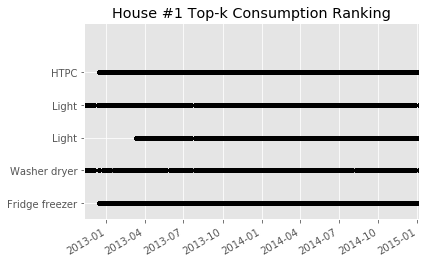

18/18 ElecMeter(instance=19, building=2, dataset='UK-DALE', appliances=[Appliance(type='cooker', instance=1)])ce=1)])]))

House #2 Top-k Consumption Ranking:

1º Fridge - 14 (16.4%) | janela = 720
2º Dish washer - 13 (15.1%) | janela = 2040
3º Computer monitor - 3 (13.6%) | janela = 999
4º Kettle - 8 (13.1%) | janela = 999
5º Computer - 5 (10.6%) | janela = 999


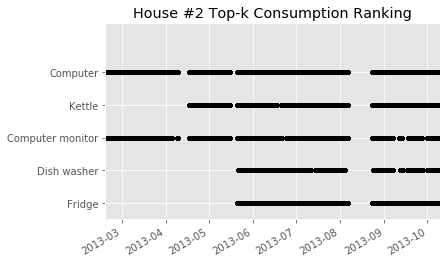

4/4 ElecMeter(instance=5, building=3, dataset='UK-DALE', appliances=[Appliance(type='projector', instance=1)])e=1)])e=1)])

House #3 Top-k Consumption Ranking:

1º Electric space heater - 3 (57.2%) | janela = 999
2º Laptop computer - 4 (19.2%) | janela = 999
3º Projector - 5 (16.5%) | janela = 999
4º Kettle - 2 (7.0%) | janela = 999


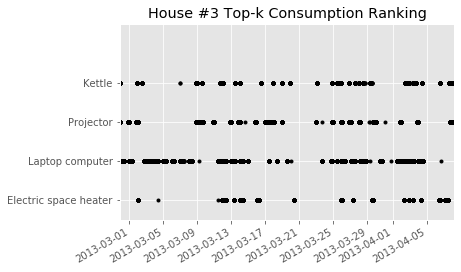

5/5 ElecMeter(instance=6, building=4, dataset='UK-DALE', appliances=[Appliance(type='washing machine', instance=1), Appliance(type='microwave', instance=1), Appliance(type='breadmaker', instance=1)])liance(type='light', instance=1)])

House #4 Top-k Consumption Ranking:

1º Freezer - 5 (29.8%) | janela = 999
2º Boiler - 4 (26.6%) | janela = 999
3º Television - 2 (15.5%) | janela = 999
4º Washing machine - 6 (14.2%) | janela = 2040
5º Kettle - 3 (13.9%) | janela = 999


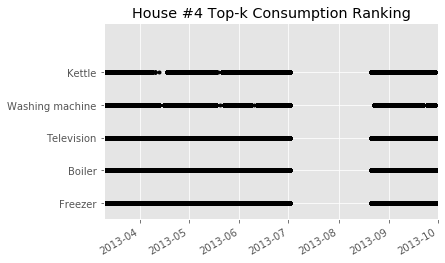

24/24 ElecMeter(instance=25, building=5, dataset='UK-DALE', appliances=[Appliance(type='vacuum cleaner', instance=1)])))e=1)])

House #5 Top-k Consumption Ranking:

1º Desktop computer - 3 (17.5%) | janela = 999
2º Server computer - 9 (17.3%) | janela = 999
3º Microwave - 23 (11.5%) | janela = 900
4º Washer dryer - 24 (10.6%) | janela = 2040
5º Fridge freezer - 19 (9.9%) | janela = 720


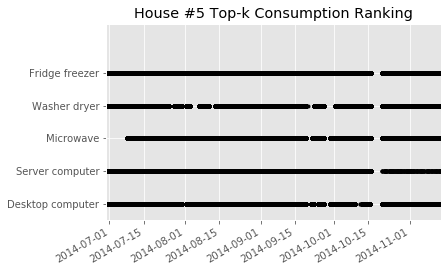

In [23]:
# Aparelhos que mais consomem energia no dataset
dataset = ukdale
for b in dataset.buildings:
    building = dataset.buildings[b]
    top = building.elec.submeters().select_top_k(k=TOP_K)
    energy_per_meter = building.elec.submeters().fraction_per_meter().sort_values(ascending=False) # % kWh
    print(f'\n\nHouse #{building.identifier.instance} Top-k Consumption Ranking:\n')

    for i, m in enumerate(top.meters):
        label = m.label().lower().replace(' ','_')
        prop = energy_per_meter.values[i] * 100 # % energy 
        # if not any(map(label.__contains__, aparelhos_janelas.keys())) and label != 'site_meter':
        #     aparelhos_janelas_dataset[label] = JANELA_PADRAO
        tamanho_janela = 999
        for k, v in aparelhos_janelas.items():
            if k in label:
                tamanho_janela = v
                break
        
        print(f'{i+1}º', f'{m.label()} - {m.instance()} ({prop:.1f}%) | janela = {tamanho_janela}')

    top.plot_when_on()
    plt.title(f'House #{building.identifier.instance} Top-k Consumption Ranking')
    plt.show()

In [24]:
# Consolidando dados ukdale (pré-treino)
dados_ukdale = carregar_dados(
    ukdale,  
    periodo=PERIODO,
    residencias=None,
    janelas_otimizadas=aparelhos_janelas,  # conhecimento a priori das melhores janelas por aparelho
    janela_padrao=JANELA_PADRAO, 
    top_k_consumo=TOP_K,
    ignorar_janelas_vazias=True,
    estatisticas=False,
    metadados=False,
    debug=True
    )

> Processando residência #1...
* Extraindo consumo agregado dos medidores...
Residencia: Building(instance=1, dataset='UK-DALE')
  - Consumo agregado: de 2012-11-09 22:28:14+00:00 a 2015-01-05 06:27:12+00:00
* Obtendo aparelhos com maiores consumo de energia...
52/52 ElecMeter(instance=53, building=1, dataset='UK-DALE', appliances=[Appliance(type='printer', instance=1)])ance=1)])e(type='external hard disk', instance=1)])e=2), Appliance(type='radio', instance=3)])1)])config_aparelhos {'fridge_freezer - 12': 720, 'washer_dryer - 5': 2040, 'light - 25': 900, 'light - 8': 900, 'htpc - 9': 900}

* Gerando janelas de consumo para cada canal/aparelho...
   - Consumo aparelho washer_dryer: de 2012-11-09 22:28:18+00:00 a 2013-01-08 22:28:18+00:00 | (2592001,) >>> 0.0 16442.965 613.57794 826.2863
  - Consumo agregado/aparelho: de  2012-11-09 22:28:18+00:00 a 2013-01-08 22:28:18+00:00 | (2592001,) >>> 0.0 6368.0 263.10522 393.6171
  - Shapes sincronizados? True
   - Consumo aparelho light: de 201

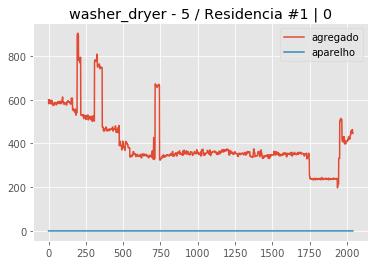

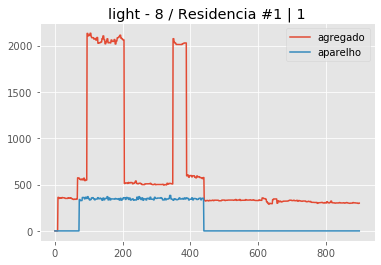

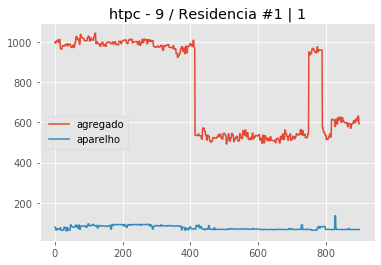

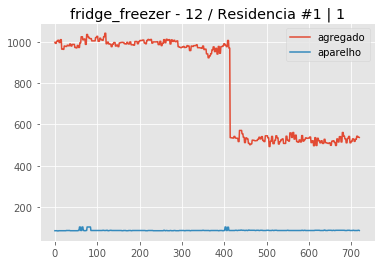

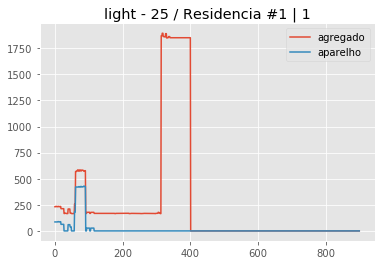

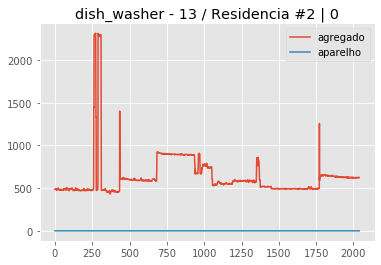

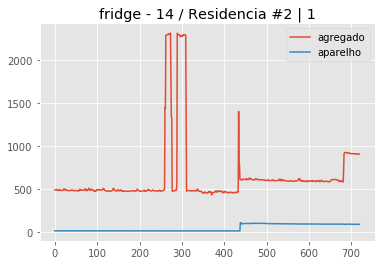

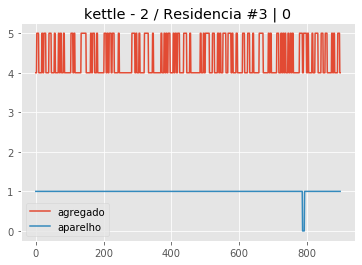

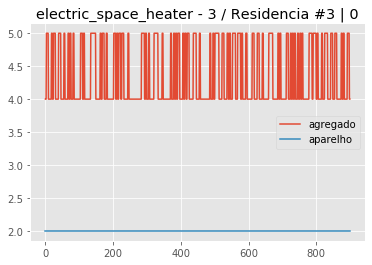

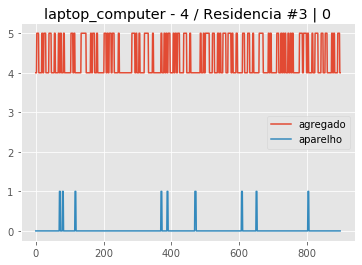

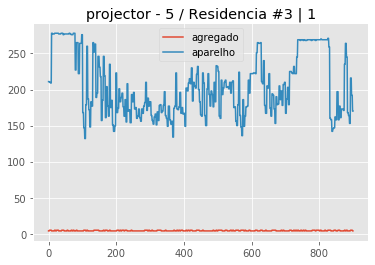

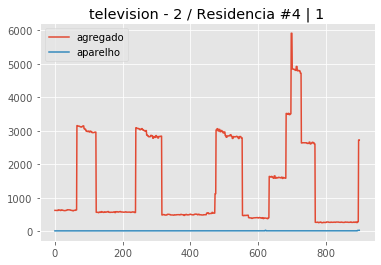

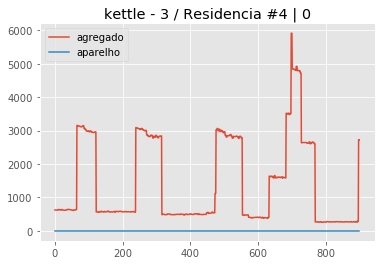

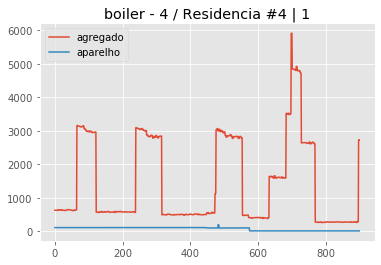

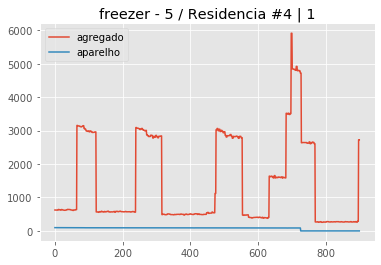

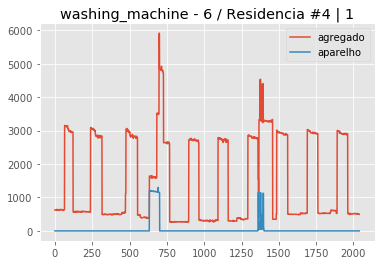

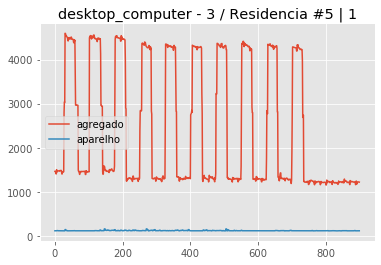

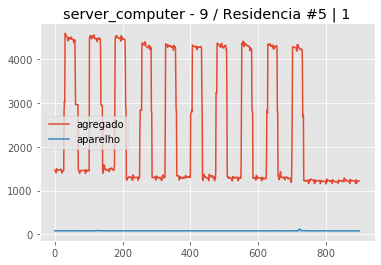

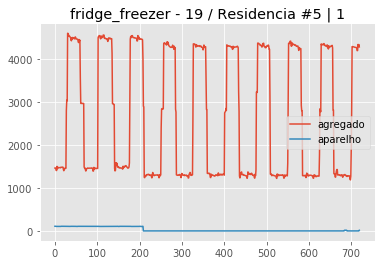

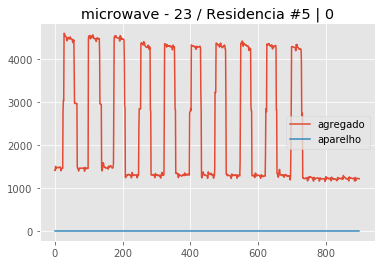

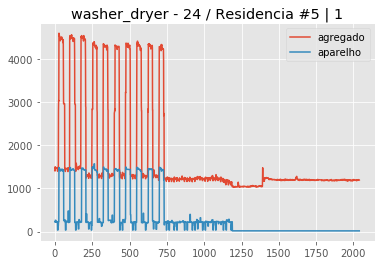

In [25]:
for d in dados_ukdale:
    fig = plt.figure();
    plt.plot(d['janelas'][0])
    plt.plot(d['consumo'][0])
    plt.title(f"{d['aparelho']} - {d['instancia']} / Residencia #{d['residencia']} | {d['status'][0]}");
    plt.legend(['agregado', 'aparelho'])
    plt.show()

In [26]:
nome_dataset = 'ukdale'

print(f'Persistindo dados ({nome_dataset}) de {len(dados_ukdale)} aparelho(s)...')
for d in dados_ukdale:

    total_amostras = d['janelas'].shape[0]
    total_amostras_treino = np.ceil(total_amostras * split_treino).astype(int) - 1
    for i, (janela, status) in tqdm(enumerate(zip(d['janelas'], d['status'])), total=total_amostras):
        # converter janela para rp    
        amostra = os.path.join(
            caminho_amostras, 
            'treino' if i < total_amostras_treino else 'teste',
            str(status), 
            # f"{nome_dataset}_{i}_{d['aparelho']} - {d['instancia']}.png"
            f"{nome_dataset}_{i}_house_{d['residencia']}_{d['aparelho']} - {d['instancia']}.png"
            )
        Path(amostra).parent.mkdir(parents=True, exist_ok=True)
        # print(i, amostra)

        rp = converter_serie_para_rp(
            janela,
            input_shape=TAMANHO_IMAGEM_DLAFE,
            data_type=np.float32,
            normalize=False, 
            standardize=False, 
            rescale=False)
        # plt.imshow(rp);
        # plt.show()
        plt.imsave(amostra, rp[:,:,0], origin='lower')
        # break

Persistindo dados (ukdale) de 21 aparelho(s)...


100%|██████████| 1270/1270 [09:50<00:00,  2.15it/s]


In [27]:
if dados_ukdale: del dados_ukdale
gc.collect()

56474

### REDD

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 Me

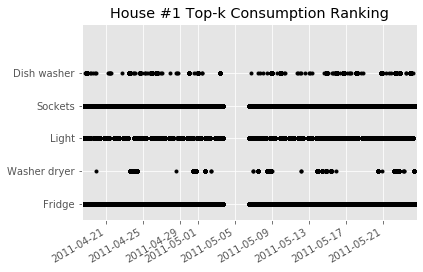

9/9 ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])

House #2 Top-k Consumption Ranking:

1º Fridge - 9 (52.9%)
2º Light - 4 (17.6%)
3º Microwave - 6 (10.2%)
4º Sockets - 8 (6.8%)
5º Dish washer - 10 (5.9%)


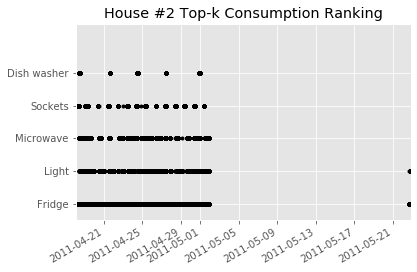

19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

House #3 Top-k Consumption Ranking:

1º CE appliance - 6 (26.6%)
2º Washer dryer - (13, 14) (19.8%)
3º Fridge - 7 (12.1%)
4º Light - 11 (10.4%)
5º Light - 17 (9.2%)
Loading data for meter ElecMeterID(instance=14, building=3, dataset

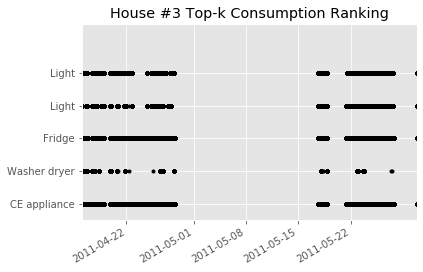

17/17 MeterGroup(meters==20, building=4, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=9, building=4, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=10, building=4, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=1)])
17/17 MeterGroup(meters==20, building=4, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=9, building=4, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=10, building=4, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=1)])
Calculating total_energy for ElecMeterID(instance=10, building=4, dataset='REDD') ...   

House #4 Top-k Consumption Ranking:

1º Electric furnace - 4 (38.8%)
2º Sockets - 14 (24.8%)
3º Light - 13 (13.0%)
4º Light - 3 (8.7%)
5º Electric stove - 8 (3.4%)


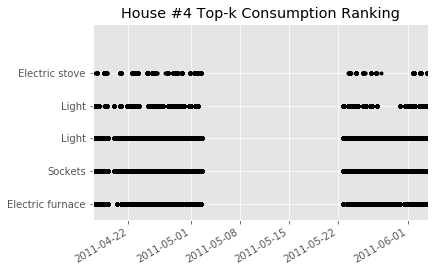

21/22 MeterGroup(meters==26, building=5, dataset='REDD', appliances=[Appliance(type='sockets', instance=6)])=1)])ce=1)])
  ElecMeter(instance=8, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=9, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
22/22 MeterGroup(meters= for ElecMeterID(instance=9, building=5, dataset='REDD') ...   
  ElecMeter(instance=12, building=5, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=13, building=5, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
21/22 MeterGroup(meters==26, building=5, dataset='REDD', appliances=[Appliance(type='sockets', instance=6)])=1)])ce=1)])
  ElecMeter(instance=8, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=9, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1

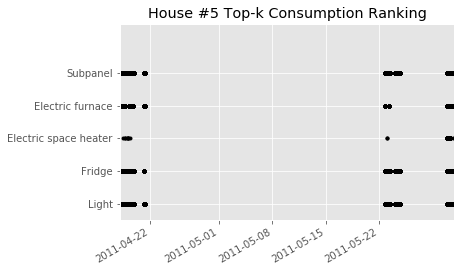

14/14 MeterGroup(meters==15, building=6, dataset='REDD', appliances=[Appliance(type='air handling unit', instance=1)])1)])
  ElecMeter(instance=16, building=6, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=17, building=6, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=1)])
14/14 MeterGroup(meters==15, building=6, dataset='REDD', appliances=[Appliance(type='air handling unit', instance=1)])1)])
  ElecMeter(instance=16, building=6, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=17, building=6, dataset='REDD', appliances=[Appliance(type='air conditioner', instance=1)])
Calculating total_energy for ElecMeterID(instance=17, building=6, dataset='REDD') ...   

House #6 Top-k Consumption Ranking:

1º Light - 14 (27.5%)
2º Air conditioner - (16, 17) (25.6%)
3º Fridge - 8 (18.9%)
4º Air handling unit - 15 (6.9%)
5º Sockets - 11 (6.4%)
Loading data for meter ElecMeterID(in

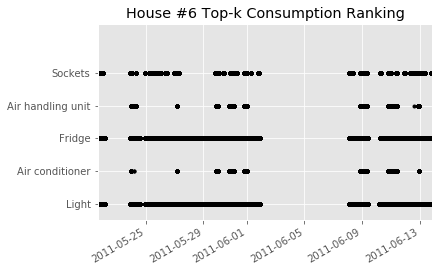

In [28]:
# Expandindo p/ aparelhos que mais consomem energia no dataset
dataset = redd
for b in dataset.buildings:
    building = dataset.buildings[b]
    top = building.elec.submeters().select_top_k(k=TOP_K)
    energy_per_meter = building.elec.submeters().fraction_per_meter().sort_values(ascending=False) # % kWh
    print(f'\n\nHouse #{building.identifier.instance} Top-k Consumption Ranking:\n')

    for i, m in enumerate(top.meters):
        label = m.label().lower().replace(' ','_')
        prop = energy_per_meter.values[i] * 100 # % energy 
        print(f'{i+1}º', f'{m.label()} - {m.instance()} ({prop:.1f}%)')
        # if not any(map(label.__contains__, aparelhos_janelas.keys())) and label != 'site_meter':
        #     aparelhos_janelas_dataset[label] = JANELA_PADRAO

    top.plot_when_on()
    plt.title(f'House #{building.identifier.instance} Top-k Consumption Ranking')
    plt.show()

In [29]:
# Exportando base de teste (redd)

# Listas de cargas a nao exportar (utilizada na validacao dos resultados)
cargas_estudo = set([c.split(' - ')[0] for c in df_melhores_taxas_janelas['carga'].values])

# Consolidando dados redd (pré-treino)
dados_redd = carregar_dados(
    redd,  
    periodo=PERIODO,
    residencias=None,
    janelas_otimizadas=aparelhos_janelas,  # conhecimento a priori das melhores janelas por aparelho
    janela_padrao=JANELA_PADRAO, 
    top_k_consumo=TOP_K,
    ignorar_janelas_vazias=True,
    estatisticas=False,
    metadados=False,
    debug=True
    )

> Processando residência #1...
* Extraindo consumo agregado dos medidores...
Residencia: Building(instance=1, dataset='REDD')
  - Consumo agregado: de 2011-04-18 09:22:08-04:00 a 2011-05-24 15:57:02-04:00
* Obtendo aparelhos com maiores consumo de energia...
15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   con

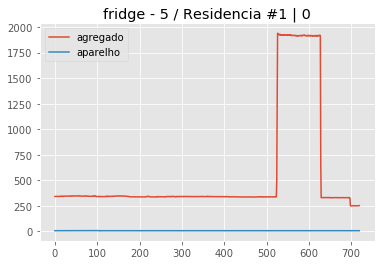

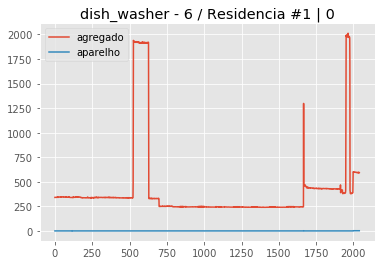

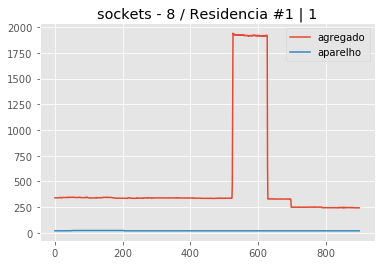

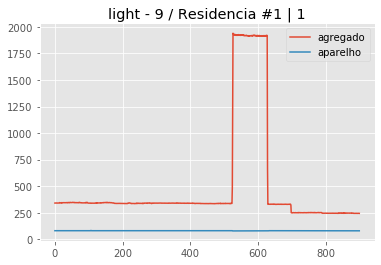

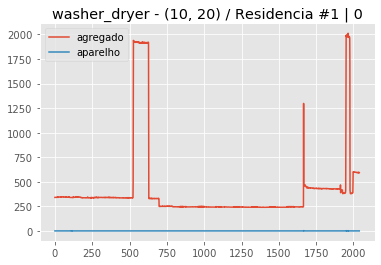

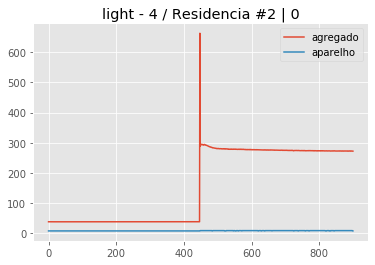

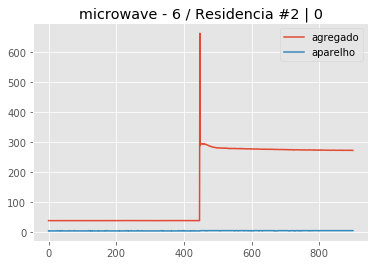

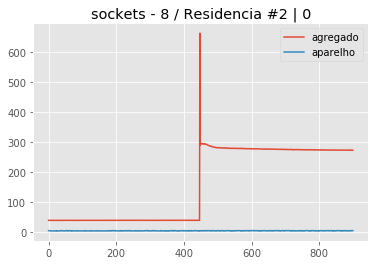

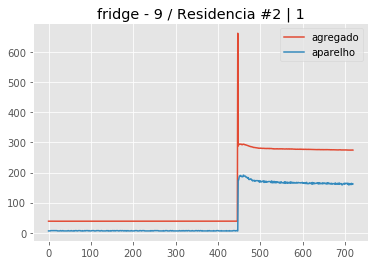

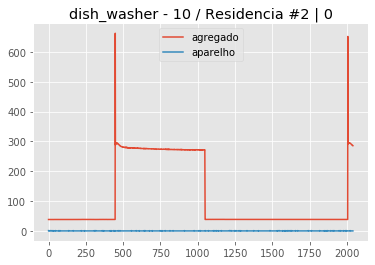

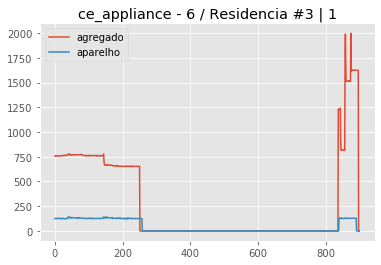

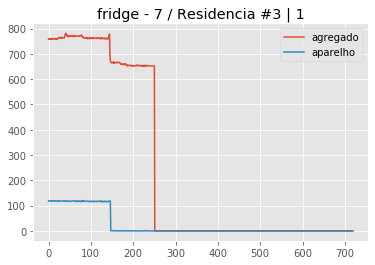

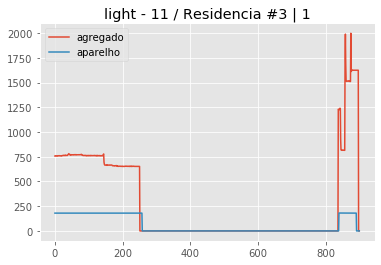

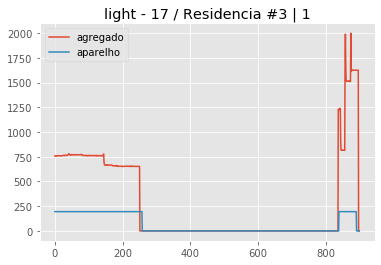

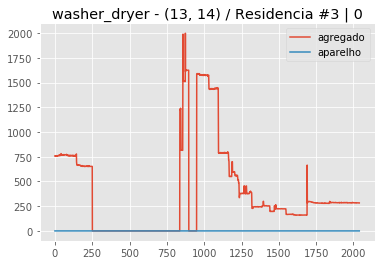

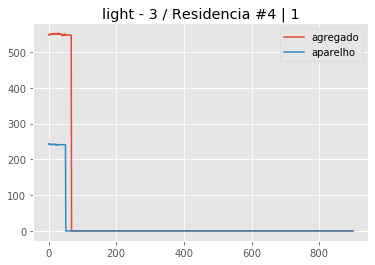

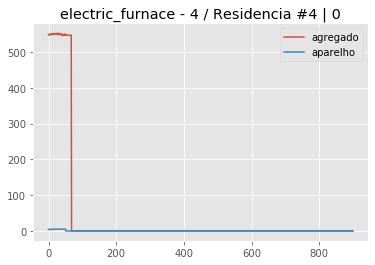

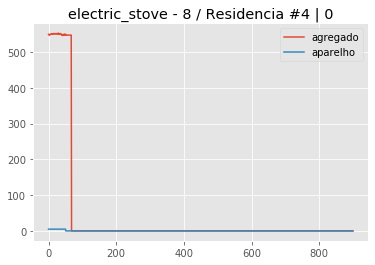

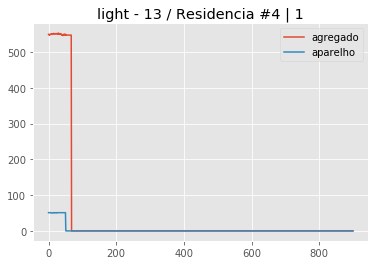

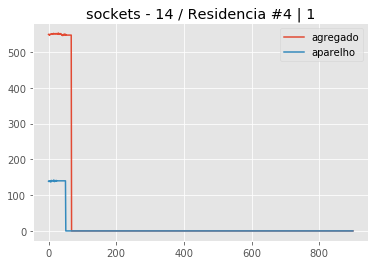

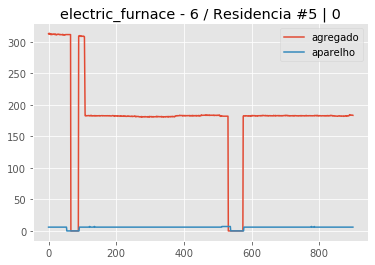

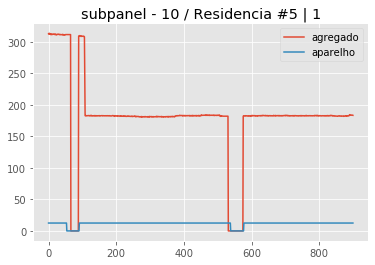

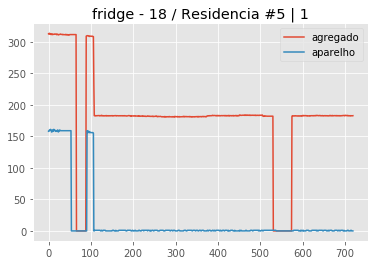

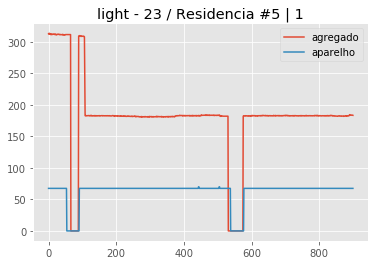

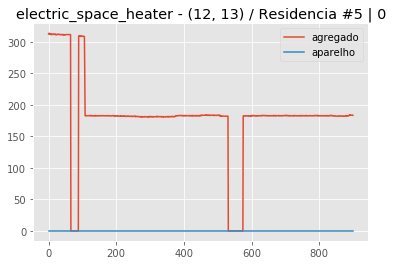

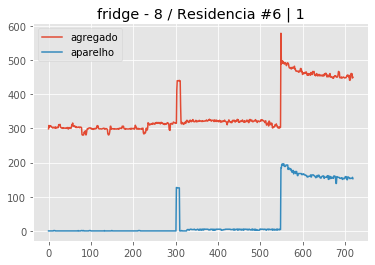

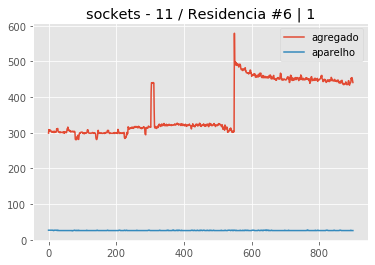

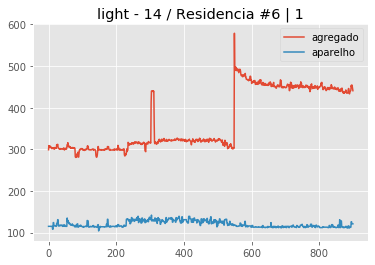

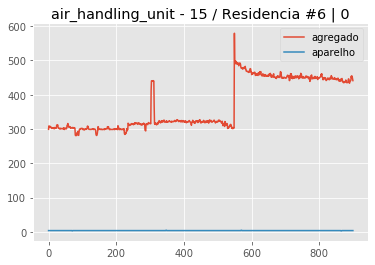

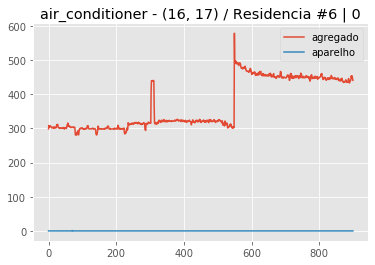

In [30]:
for d in dados_redd:
    fig = plt.figure();
    plt.plot(d['janelas'][0])
    plt.plot(d['consumo'][0])
    plt.title(f"{d['aparelho']} - {d['instancia']} / Residencia #{d['residencia']} | {d['status'][0]}");
    plt.legend(['agregado', 'aparelho'])
    plt.show()

In [31]:
nome_dataset = 'redd'

print(f'Persistindo dados ({nome_dataset}) de {len(dados_redd)} aparelho(s)...')
for d in dados_redd:

    # Ignorar dados da casa 3 utilizadas na validacao dos resultados
    if not d['residencia'] == 3 and any(map(d['aparelho'].__contains__, cargas_estudo)):

        total_amostras = d['janelas'].shape[0]
        total_amostras_treino = np.ceil(total_amostras * split_treino).astype(int) - 1
        for i, (janela, status) in tqdm(enumerate(zip(d['janelas'], d['status'])), total=total_amostras):
            
            # Ignorar janelas vazias
            if np.sum(janela) > 0:
            
                # converter janela para rp    
                amostra = os.path.join(
                    caminho_amostras, 
                    'treino' if i < total_amostras_treino else 'teste',
                    str(status), 
                    f"{nome_dataset}_{i}_house_{d['residencia']}_{d['aparelho']} - {d['instancia']}.png"
                    )
                Path(amostra).parent.mkdir(parents=True, exist_ok=True)
                # print(i, amostra)

                rp = converter_serie_para_rp(
                    janela,
                    input_shape=TAMANHO_IMAGEM_DLAFE,
                    data_type=np.float32,
                    normalize=False, 
                    standardize=False, 
                    rescale=False)
                # plt.imshow(rp);
                # plt.show()
                plt.imsave(amostra, rp[:,:,0], origin='lower')
                # break

  0%|          | 0/1106 [00:00<?, ?it/s]

Persistindo dados (redd) de 30 aparelho(s)...


100%|██████████| 1103/1103 [08:32<00:00,  2.15it/s]


In [32]:
## Apagando registros
if dados_redd: del dados_redd
gc.collect()

87759

# FIM!

In [33]:
%load_ext watermark

In [34]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Author: Diego Luiz Cavalca

Last updated: Fri Aug 05 2022 19:23:37Hora oficial do Brasil

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: a08755103e8347c8e35f0215bdb86d5bb13c7927

